# OptimizerMethod-MiniBatch(Application)

在这里我们尝试一下Batch与Mini-Batch.

In [1]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

### Load Dataset

The dataset is named "moons" because the data from each of the two classes looks a bit like a crescent-shaped moon.

In [2]:
def load_dataset(n_sample):
    np.random.seed(3)
    X, y = datasets.make_moons(n_samples=n_sample, noise=.15) #300 #0.2 
    # Visualize the data
    plt.scatter(X[:, 0], X[:, 1], c=y, s=5, cmap=plt.cm.Spectral);
    
    
    return X,y.reshape(-1,1)

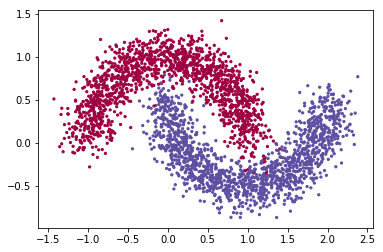

In [3]:
train_x,train_y = load_dataset(3000)

### Gradient Descent Vs. Stochastic Gradient Descent

当数据集非常大时,您可能需要使用以下方法

在Stochastic Gradient Descent中,在更新渐变之前,您只使用1个训练示例.当训练集很大时,SGD可以更快.但是参数将"振荡"到最小值而不是平滑地收敛.这是一个例子:

![](../../picture/89.png)

实际上,如果您既不使用整个训练集,也不使用一个训练示例来执行每次更新,则通常会获得更快的结果.小批量梯度下降使用每个步骤的中间数量的示例.通过小批量梯度下降,您可以循环使用Mini-batchs，而不是循环遍历各个training data set.

![](../../picture/90.png)

**Ps:**

> 这里提到的SGD与Mini-Batch GD实际上不一样的就是迭代的样本数量,SGD:随机更新一个样本的梯度,而Mini-Batchs随机更新一个批次(batch size)的梯度.

> 为了符合计算机的运行原理,batch size 经常等于$2^n$,当然这不是一定的,像后面提到的Batch Normalization 作者使用的就是60.

> 无论如何由于具有良好的小批量,通常它优于Gradient Descent或Stochasitc Gradient Descent(特别是当训练集很大时,一般是大于2000个样本).

如果我们要使用Mini-Batch Gradient Descent,那么我们一定要建立随机Batch Size样本

主要由两个步骤构成:

(1) 随机将训练样本完全打乱

![](../../picture/91.png)

(2) 依照提供的batch size(64)进行分区

![](../../picture/92.png)

**Ps:**

> 在依照batch size进行分区的时候可能会发生样本数量无法整除batch size的情况即,最后会有一部分多余出来,那么我们就将其独立出来(样本批次小于64).

>也就是说最后划分出来的结果为:总组数=N组完整划分的数据+1组非完整划分的数据

>在很多深度学习框架中,将Mini-Batch GD唤做SGD,因为本来两者就只是batch size的不同.比如在Pytorch中只有SGD,没有MiniBatch GD和GD,实际上我们只要控制batch size的大小就能完成转变,比如batch size = 1即为SGD.比如batch size = m即为GD.

### Split  Mini-batch data

我们使用函数

```python
def random_miniBatch(batch_size,data,labels,seed):
    ...```
    
来达到依照batch size随机划分训练集的效果.

**代码解释:**

[1] 我们需要使用[np.random.permutation()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html)来将m个样本重新排序,这样做的目的是,我们可以将函数返回值看做索引,使用索引将数据全部重新排序,那么就可以保证labels与data还是一一对应的.

[2] 

```python
shuffle_X = data[premutation_index,:]
shuffle_y = labels[premutation_index,:]```

使用```premutation_index```将数据重新排序.

[3]

```python
num_complet_miniBatch = m // batch_size```

依照提供的batch size查看能划分为多少整组,意思就是如果batch size=64,那么结果即表示为有多少个完整的64.

[4]

```python
for k in range(num_complet_miniBatch):
    ...```

获取整数组(64)的样本,并将其放入在```mini_batchs```列表中,列表中的每一项是一个元组分别为```mini_batch_X```和```mini_batch_y```.

[5]

```python
if m % num_complet_miniBatch !=0:
    ...```
    
如果模不为0,说明使用提供的batch size无法完整划分数据集,会产生最后一组不足64个样本的组.那么我们就将剩下的数据放入```mini_batchs```.

In [5]:
def random_miniBatch(batch_size,data,labels,seed):
    """
    Random Split data -- MiniBatchs
    Arguments:
    ---------
        batch_size: batch size to split data set,can choose 2^n.
        data: split data.
        labels: split data labels.
        seed: random seed,make sure the result same in every running.
    Return:
    ------
       mini_batchs: mini batchs, it's a list, include mini_batch_X,mini_batch_y.
    """
    
    np.random.seed(seed)
    m,n = data.shape
    mini_batchs = []
    
    premutation_index = np.random.permutation(m) # permutation m,return shuffle 0->m.
    # shuffle data and labels.
    shuffle_X = data[premutation_index,:] 
    shuffle_y = labels[premutation_index,:]
    
    # get divisible part.
    num_complet_miniBatch = m // batch_size
    
    # Spliting data and labels.
    for k in range(num_complet_miniBatch):
        mini_batch_X = shuffle_X[k * batch_size:(k+1)*batch_size,:]
        mini_batch_y = shuffle_y[k * batch_size:(k+1)*batch_size,:]
        mini_batch = (mini_batch_X,mini_batch_y)
        # append the mini_batchs list
        mini_batchs.append(mini_batch)
        
    # if have can not divisible part, then append mini_batch list last part.
    if m % num_complet_miniBatch !=0:
        mini_batch_X = shuffle_X[num_complet_miniBatch * batch_size:,:]
        mini_batch_y = shuffle_y[num_complet_miniBatch * batch_size:,:]
        mini_batch = (mini_batch_X,mini_batch_y)
        mini_batchs.append(mini_batch)
        
    return mini_batchs 

### Build Gradient Descent and Mini-Batch Gradient Descent

Model含有的主要功能有1.运行GD,2.运行MiniBatch(Mini-batch GD).

**函数对照表:**

[1]

```python
def __init__(self,layers,epochs,alpha,print_step,mode):
    ...```
    
初始化类,其中```mode```可选择为:1.GD:Gradient Descent,2.MiniBatch:SGD(MiniBatch GD).

[2]

```python
def init_parameters(self):
    ...```
    
初始化权重$W$和bias$b$,这里采用"He"的初始化方式.

[3]

Activacion Functions and loss function

```python
def sigmoid(self,Z):
    ...```
    
```python
def sigmoid(self,Z):
    ...```

```python
def cost(self,A,y):
    ...```
    
使用Binary Cross Entropy.

[4]

```python
def forward(self,X,parameters):
    ...```
    
实现Forward Propagation.

[5]

```python
def backward(self,A,y,cache,parameters):
    ...```

实现Backward Propagation.

[6]

```python
def update(self,dparameters,parameters):
    ...```
    
Updating Parameters.


[7]

```python
def score(self,data,labels,parameters):
    ...```
    
当每迭代到一定步长的时候,我们计算一样训练样本的正确率.

[8]

```python
def train_GD(self,data,labels,parameters):
    ...```

当```mode```选择为"GD"的时候走该函数进行训练.

[9]

```python
def train_Minibatch(self,batch_size,data,labels,parameters):
    ...```
    
当```mode```选择为"MiniBatch"的时候,选择该函数进行训练.

两者的区别仅仅是多了一个for loop,后者每一个epoch都将迭代完所有的batchs才运行下一个epoch,这样也就达到了GD做一次迭代,MinibatchGD做已经做完N(所有划分样本组数)次迭代.


[10]

```python
def fit(self,data,labels,batch_size = None):
    ...```
    
训练启动函数,初始化权重,偏置,并依照提供的```mode```选择运行不同的模型.

[11]

```python

def plot_decision_boundary(self,X,Y,parameters,title):
    ...```
    
绘制决策边界.




In [28]:
class Model:
    
    def __init__(self,layers,epochs,alpha,print_step,mode):
        """
        Initialization class Model
        Arguments:
        ---------
            layers: hidden layers's units.
            epochs: Number of Iterate.
            alpha: learning rate.
            print_step: print information of each N step.
            mode: running mode, can choose:1.GD:Gradient Descent,2.MiniBatch(Mini-batch GD or SGD).
        """
        self.layers = layers
        self.epochs = epochs
        self.alpha = alpha
        self.print_step = print_step
        self.mode = mode
    
    def init_parameters(self):
        """
        Initialization Parameters include weights and bias.
        
        Returns:
        -------
            parameters: include weights and bias.
        """
        np.random.seed(4)
        parameters = {}
        for l in range(self.L-1):
            W = np.random.randn(self.layers[l],self.layers[l+1]) * np.sqrt(2/self.layers[l])
            b = np.zeros((1,self.layers[l+1]))
            parameters['W'+str(l+1)] = W
            parameters['b'+str(l+1)] = b
            
        return parameters
        
    def sigmoid(self,Z):
        """
        Sigmoid activation
        """
        return 1./(1.+np.exp(-Z))
    
    def relu(self,Z):
        """
        RELU activation 
        """
        return np.maximum(0,Z)
    
    def cost(self,A,y):
        """
        loss function: binary cross entropy.
        """
        m = y.shape[0]
        loss = - np.sum(np.multiply(y,np.log(A))+np.multiply((1-y),np.log(1-A))) /m
        return loss
    
    def forward(self,X,parameters):
        """
        Implement Forward Propagation 
        Arguments:
        --------
            X: training data set.
            parameters: include weights and bias.
            
        Returns:
        -------
            A: last layers value,output layer values.
            cache: cache A and Z to using backward propagation.
        """
        A = X
        cache = {'A0':X}
        for l in range(self.L-1):
            W,b = parameters['W'+str(l+1)],parameters['b'+str(l+1)]
            Z = np.add(np.dot(A,W),b)
            cache['Z'+str(l+1)] = Z
            if l != self.L - 2:
                A = self.relu(Z)
            else:
                A = self.sigmoid(Z)
            cache['A'+str(l+1)] = A
            
        return A,cache
    
    def backward(self,A,y,cache,parameters):
        """
        Implment Backward Propagation
        Arguments:
        --------
            A:last layers value,output layer values.
            y: true labels.
            cache:cache A and Z in forward
            parameters: include weights and bias.
        Returns:
        -------
            dparameters: include dW,db to using updating parameters.
            
        """
        m = y.shape[0]
        dparameters = {}
        for l in range(self.L-1,0,-1):
            if l == self.L-1:
                dZ = A - y
            else:
                dZ = np.multiply(dA,np.int64(cache['Z'+str(l)]>0))
                
            A = cache['A'+str(l-1)]
            dW = np.dot(A.T,dZ) /m
            db = np.sum(dZ,axis=0,keepdims=True) / m
            dparameters['dW'+str(l)] = dW
            dparameters['db'+str(l)] = db
            
            if l != 1:
                W = parameters['W'+str(l)]
                dA = np.dot(dZ,W.T)
        return dparameters
    
    def update(self,dparameters,parameters):
        """
        Updating parameters
        Arguments:
        ---------
            dparameters: Derivative weights and derivative bias in backward.
            parameters: include weights and bias.
        
        Return:
        ------
            parameters: updated weights and bias.
        """
        for l in range(self.L-1):
            parameters['W'+str(l+1)] -= self.alpha * dparameters['dW'+str(l+1)]
            parameters['b'+str(l+1)] -= self.alpha * dparameters['db'+str(l+1)]
            
        return parameters
       
        
    def score(self,data,labels,parameters):
        """
        Get correct rate of target data set.
        Arguments:
        ---------
            data: score data.
            labels: score labels.
            parameters: The best weights and bias.
        Return:
        ------
            accuracy of target data set.
        """
        m = labels.shape[0]
        A,_ = self.forward(data,parameters)
        predict = np.round(A)
        
        acc = np.equal(predict,labels).sum()/ m
        
        return acc
    
    def train_GD(self,data,labels,parameters,title):
        """
        Training of Gradient Descent.
        Arguments:
        ---------
            data: training date set.
            labels: training labels.
            parameters: weights and bias.
            title: plot decision bounary parameter.
            
        Return:
        ------
            loss_: loss value in each print_step
            acc_trains: train correct rate in each print_step.
        """
        loss_ = []
        acc_trains = []
        for epoch in range(self.epochs):
            A,cache = self.forward(data,parameters)
            loss = self.cost(A,labels)
            dparameters = self.backward(A,labels,cache,parameters)
            parameters = self.update(dparameters,parameters)
            
            if epoch % self.print_step == 0:
                
                acc_train = self.score(data,labels,parameters)
                loss_.append(loss)
                acc_trains.append(acc_train)
                print('[{}/{}] loss:{} acc train:{}'.format(epoch+self.print_step,self.epochs,loss,acc_train))
        
        self.plot_decision_boundary(data,labels,parameters,title)
        
        return loss_,acc_trains
        
    def train_Minibatch(self,batch_size,data,labels,parameters,title):
        """
        Training of SGD.
        Arguments:
        ---------
            batch_size: split batch size.
            data: training date set.
            labels: training labels.
            parameters: weights and bias.
            title: plot decision bounary parameter.
            
        Return:
        ------
            loss_: loss value in each print_step
            acc_trains: train correct rate in each print_step.
        """
        loss_ = []
        acc_trains = []
        seed = 0 # set random seed in split data.
        
        for epoch in range(self.epochs):
            seed += 1 # make sure function np.random.permutaion result is different.means shuffle data in every epoch.
            mini_batchs = random_miniBatch(batch_size=batch_size,data=data,labels=labels,seed=seed)
            
            # start mini-batch training.
            for mini_X,mini_y in mini_batchs:
                
                A,cache = self.forward(mini_X,parameters)
                loss = self.cost(A,mini_y)
                dparameters = self.backward(A,mini_y,cache,parameters)
                parameters = self.update(dparameters,parameters)
                
            if epoch % self.print_step == 0:
                
                acc_train = self.score(data,labels,parameters)
                loss_.append(loss)
                acc_trains.append(acc_train)
                print('[{}/{}] loss:{} acc train:{}'.format(epoch+self.print_step,self.epochs,loss,acc_train))

        self.plot_decision_boundary(data,labels,parameters,title)
        
        return loss_,acc_trains
    
        
        
        
    def fit(self,data,labels,batch_size = None,title=None):
        """
        Fitting Model.
        Arguments:
        ---------
            data: training data set. shape is (m,n_x)
            labels: training labels. shape is (m,1)
            batch_size:batch size default None.
            title: using plot decision boundary default None.
            
        Return:
        ------
            loss_: loss value in each print_step
            acc_trains: train correct rate in each print_step.  
        """
        m,n = data.shape
        self.layers.insert(0,n)
        self.L = len(self.layers)
        parameters = self.init_parameters()
        
        print('Running Model %s ...'%self.mode)
        
        if self.mode == "GD":
            loss_ = self.train_GD(data,labels,parameters,title)
            return loss_
        elif self.mode == "MiniBatch":
            loss_ = self.train_Minibatch(batch_size=batch_size,data=data,labels=labels,parameters=parameters,
                                        title=title)
            return loss_
        else:
            raise ValueError('Invalid mode %s'%self.mode)
        
        
            

    def plot_decision_boundary(self,X,Y,parameters,title):
        """
        plot decision boundary
        """
        # Set min and max values and give it some padding
        x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
        y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1

        x = np.arange(x_min,x_max,0.01)
        y = np.arange(y_min,y_max,0.01)
        xx,yy = np.meshgrid(x,y) # meshgrid x and y.

        X_ = np.c_[xx.ravel(),yy.ravel()] # shape like (m,n)

        A,_ = self.forward(X_,parameters) # predict 
        
        y_hat = np.round(A) # predict y
        
        fig = plt.figure()
        plt.subplot(1,1,1)
        plt.title('model with {} '.format(title))
        plt.scatter(X_[:,0], X_[:,1], c=np.squeeze(y_hat))
        plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y),s=5,cmap=plt.cm.Spectral,linewidths=1)

### Testing Model

#### Gradient Descent

In [29]:
layers = [5,2,1]
GD_model = Model(layers=layers,epochs=10000,alpha=0.07,print_step=1000,mode="GD")

Running Model GD ...
[1000/10000] loss:0.7383851938779556 acc train:0.24633333333333332
[2000/10000] loss:0.2691665805493298 acc train:0.886
[3000/10000] loss:0.20953566051211772 acc train:0.917
[4000/10000] loss:0.04872823958351057 acc train:0.9903333333333333
[5000/10000] loss:0.03688523437231089 acc train:0.9923333333333333
[6000/10000] loss:0.033176870558717736 acc train:0.9916666666666667
[7000/10000] loss:0.031306399891855484 acc train:0.9916666666666667
[8000/10000] loss:0.030170862636474102 acc train:0.992
[9000/10000] loss:0.02943557104029984 acc train:0.9916666666666667
[10000/10000] loss:0.028930601110660207 acc train:0.9913333333333333


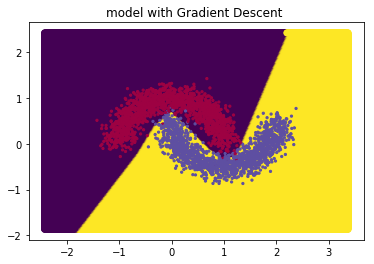

In [30]:
loss_GD,acc_GD = GD_model.fit(data=train_x,labels=train_y,title='Gradient Descent')

#### SGD(Mini-Batch Gradient Descent)

In [31]:
layers = [5,2,1]
MiniBatch_model = Model(layers=layers,epochs=10000,alpha=0.07,print_step=1000,mode="MiniBatch")

Running Model MiniBatch ...
[1000/10000] loss:0.6253716706247007 acc train:0.635
[2000/10000] loss:0.03651966453669098 acc train:0.9926666666666667
[3000/10000] loss:0.015872678790269996 acc train:0.993
[4000/10000] loss:0.0038504797163358096 acc train:0.993
[5000/10000] loss:0.05924752053641518 acc train:0.9923333333333333
[6000/10000] loss:0.0077044090906332185 acc train:0.992
[7000/10000] loss:0.02030138748598213 acc train:0.993
[8000/10000] loss:0.002699457777271225 acc train:0.993
[9000/10000] loss:0.014380436517700513 acc train:0.993
[10000/10000] loss:0.01798413131624751 acc train:0.993


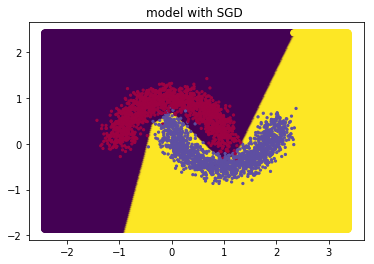

In [32]:
loss_MiniBatch,acc_MiniBatch = MiniBatch_model.fit(data=train_x,labels=train_y,batch_size=64,title='SGD')

在epochs,alpha相同的情况下,可以看到SGD的效果明显要由于GD,在2000个epoch的时候,SGD就已经达到了正确率0.9926,而GD只有0.886.更加详细的对比我们画图来展示.

In [33]:
def plot_loss(loss_GD,loss_MiniBatch,acc_GD,acc_MiniBatch):
    figrure = plt.figure(figsize=(20,4))
    
    ax1 = figrure.add_subplot(1,2,1)
    ax1.plot(loss_GD,'-o',label="Batch")
    ax1.plot(loss_MiniBatch,'-o',label="MiniBatch")
    ax1.set_title('Loss')
    ax1.set_xlabel('#Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2 = figrure.add_subplot(1,2,2)
    ax2.plot(acc_GD,'-o',label="Batch")
    ax2.plot(acc_MiniBatch,'-o',label="MiniBatch")
    ax2.set_title('Accuracy')
    ax2.set_xlabel('#Iteration')
    ax2.set_ylabel('correct rate')
    ax2.legend()

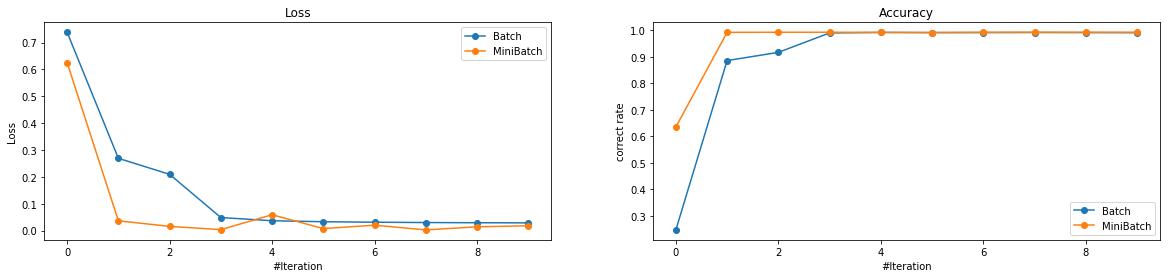

In [34]:
plot_loss(loss_GD,loss_MiniBatch,acc_GD,acc_MiniBatch)

可以看到SGD相比于GD收敛更快,实际上随着样本数量的增加,SGD的优势会越来越明显.

# Summary

(0) 在Theory中我们提到如果你打印每一个epoch的loss,你会发现SGD的震荡非常严重.这也是SGD不足的地方,在后面我们将使用优化器Optimizer来减缓这种情况.

SGD和Mini-batch的缺点:

(1) Mini-batch gradient descent 不能保证很好的收敛性,learning rate 如果选择的太小,收敛速度会很慢,如果太大,loss function 就会在极小值处不停地震荡甚至偏离.(有一种措施是先设定大一点的学习率,当两次迭代之间的变化低于某个阈值后,就减小 learning rate,不过这个阈值的设定需要提前写好,这样的话就不能够适应数据集的特点.)对于非凸函数,还要避免陷于局部极小值处,或者鞍点(马鞍点)处,因为鞍点周围的error是一样的,所有维度的梯度都接近于0,会在鞍点或者局部最小点震荡跳动,另外,如果是训练集全集带入即BGD,则优化会停止不动,如果是mini-batch或者SGD,每次找到的梯度都是不同的,就会发生震荡,来回跳动.

(2) SGD对所有参数更新时应用同样的 learning rate,如果我们的数据是稀疏的,我们更希望对出现频率低的特征进行大一点的更新.且LR会随着更新的次数逐渐变小.


最优值选择:

- 如果训练样本较小(m <=2000),直接选择batch gradient descent.
- 如果样本量大,mini-batch size: 64,512..
  - 因为考虑到电脑内置，mini-batch 一般的大小是2的n次方
- 确定你的$X^{\{t\}},Y^{\{t\}}$要符合你电脑的GPU/CPU的运行内存,如果不符合,那么你会发现算法的表现会急剧下降.